In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from IPython.display import display, HTML
from scipy.stats import chi2_contingency, f_oneway
from sklearn.preprocessing import LabelEncoder
from matplotlib.lines import Line2D

In [2]:
dataset = pd.read_csv("dataset/dataset_final.csv")
print("Number of rows in the dataset:", len(dataset))

pd.set_option('display.max_columns', None)
dataset.head(10)

Number of rows in the dataset: 52160


Driver  LapTime  LapNumber Compound  TyreLife  FreshTyre             Team  \
0    VER   91.295        3.0     SOFT       3.0      False  Red Bull Racing   
1    VER   90.503        8.0     SOFT       2.0       True  Red Bull Racing   
2    VER   89.897       11.0     SOFT       2.0       True  Red Bull Racing   
3    VER   89.708       14.0     SOFT       2.0      False  Red Bull Racing   
4    PER   91.479        3.0     SOFT       3.0      False  Red Bull Racing   
5    PER   90.746        8.0     SOFT       2.0       True  Red Bull Racing   
6    PER   90.131       11.0     SOFT       2.0       True  Red Bull Racing   
7    PER   89.846       14.0     SOFT       2.0      False  Red Bull Racing   
8    LEC   91.094        5.0     SOFT       2.0       True          Ferrari   
9    LEC   91.699       10.0     SOFT       7.0      False          Ferrari   

            EventName     Session  EventYear  AirTemp  Humidity  Pressure  \
0  Bahrain Grand Prix  Qualifying       2023     24.2      16.0    1017.5   
1  Bahrain Grand Prix  Qualifying       2023     23.8      20.0    1017.7   
2  Bahrain Grand Prix  Qualifying       2023     23.1      31.0    1017.7   
3  Bahrain Grand Prix  Qualifying       2023     23.0      33.0    1017.9   
4  Bahrain Grand Prix  Qualifying       2023     24.3      16.0    1017.5   
5  Bahrain Grand Prix  Qualifying       2023     23.8      20.0    1017.7   
6  Bahrain Grand Prix  Qualifying       2023     23.1      31.0    1017.7   
7  Bahrain Grand Prix  Qualifying       2023     23.0      33.0    1017.9   
8  Bahrain Grand Prix  Qualifying       2023     24.2      16.0    1017.5   
9  Bahrain Grand Prix  Qualifying       2023     23.8      20.0    1017.7   

   Rainfall  TrackTemp  WindDirection  WindSpeed  FuelLevel  
0     False       28.7            352        0.6        2.0  
1     False       27.8            342        0.5        2.0  
2     False       26.9            338        1.3        2.0  
3     False       26.6            329        0.8        2.0  
4     False       28.7            333        0.4        2.0  
5     False       27.8            342        0.5        2.0  
6     False       26.9            338        1.3        2.0  
7     False       26.6            329        0.8        2.0  
8     False       28.7            352        0.6        2.0  
9     False       27.8            342        0.5        2.0

In [3]:
dataset.columns

Index(['Driver', 'LapTime', 'LapNumber', 'Compound', 'TyreLife', 'FreshTyre',
       'Team', 'EventName', 'Session', 'EventYear', 'AirTemp', 'Humidity',
       'Pressure', 'Rainfall', 'TrackTemp', 'WindDirection', 'WindSpeed',
       'FuelLevel'],
      dtype='object')

In [4]:
variables = {
    'LapTime': 'Lap time (s)',
    'EventName': 'Track name',
    'Team': 'Team name',
    'Compound': 'Tyre compound',
    'TyreLife': 'Tyre life (laps)',
    'FreshTyre': 'Fresh tyre',
    'FuelLevel': 'Fuel level (kg)',
    'AirTemp': 'Air temperature (°C)',
    'Humidity': 'Humidity (%)',
    'Pressure': 'Air pressure (mbar)',
    'Rainfall': 'Rainfall',
    'TrackTemp': 'Track temperature (°C)',
    'WindDirection': 'Wind direction (°)',
    'WindSpeed': 'Wind speed (m/s)'
}


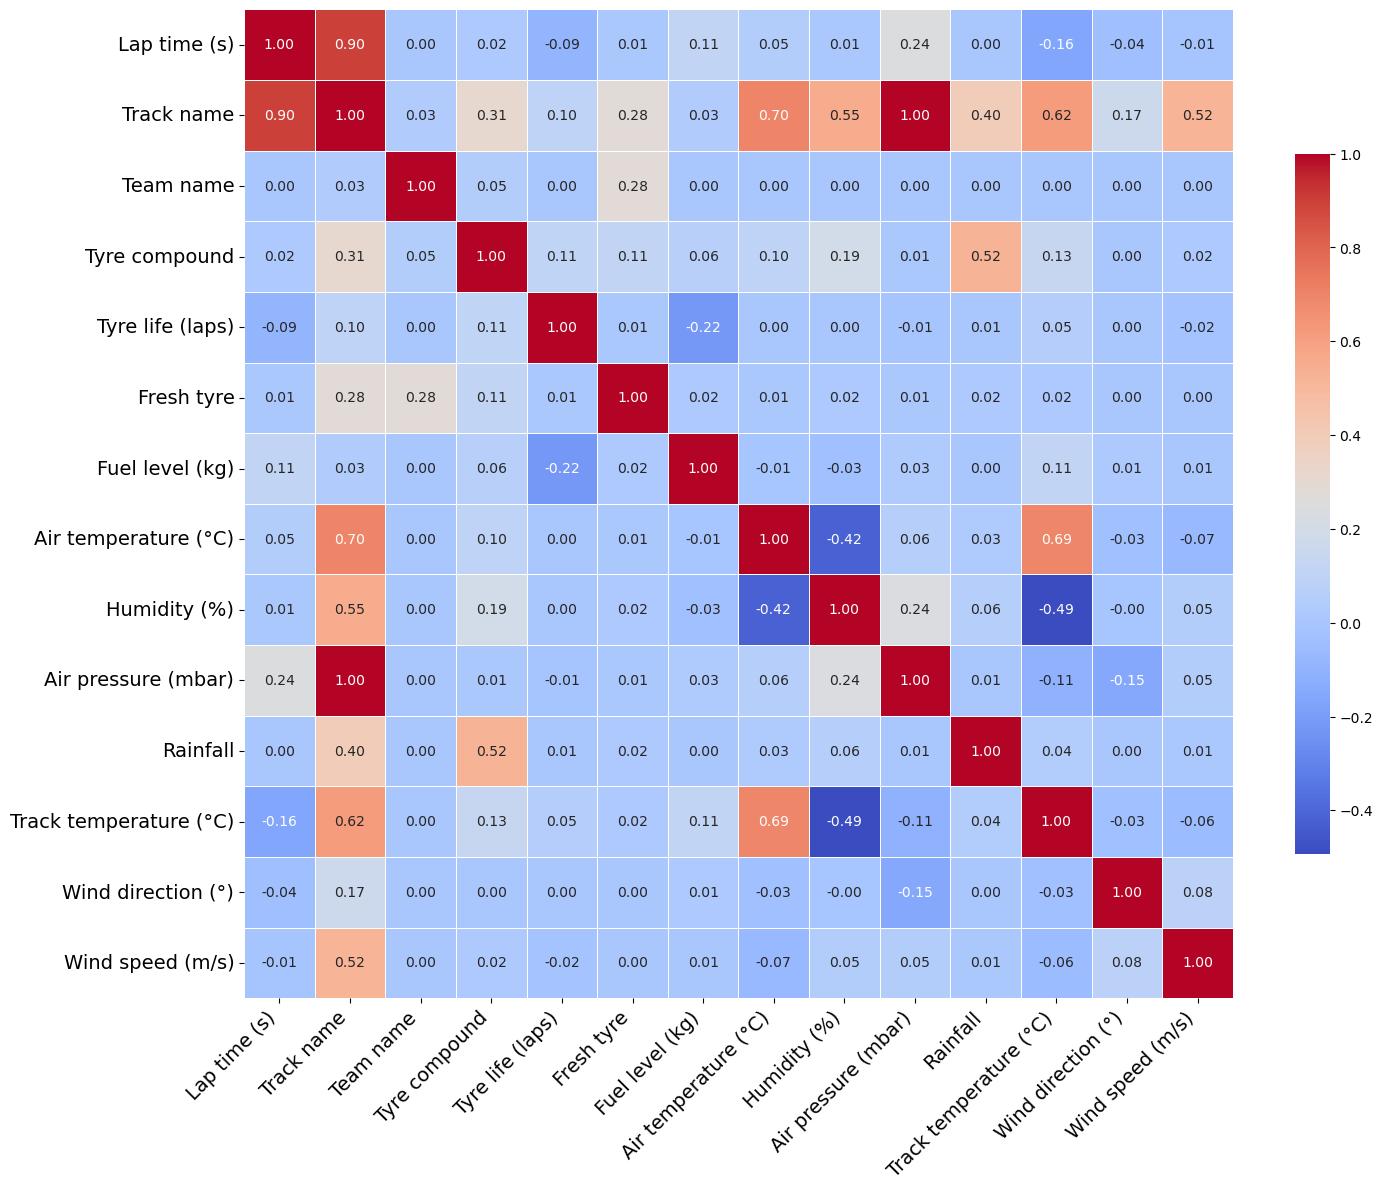

In [5]:
selected_cols = list(variables.keys())
df = dataset[selected_cols].copy()

def eta_squared(cat, num):
    try:
        categories = [num[cat == val] for val in np.unique(cat)]
        ss_between = sum(len(group) * (group.mean() - num.mean()) ** 2 for group in categories)
        ss_total = sum((num - num.mean()) ** 2)
        return ss_between / ss_total if ss_total > 0 else np.nan
    except:
        return np.nan

def cramers_v(x, y):
    try:
        confusion_matrix = pd.crosstab(x, y)
        chi2 = chi2_contingency(confusion_matrix)[0]
        n = confusion_matrix.values.sum()
        phi2 = chi2 / n
        r, k = confusion_matrix.shape
        phi2corr = max(0, phi2 - ((k - 1)*(r - 1)) / (n - 1))
        rcorr = r - ((r - 1)**2)/(n - 1)
        kcorr = k - ((k - 1)**2)/(n - 1)
        denom = min((kcorr - 1), (rcorr - 1))
        return np.sqrt(phi2corr / denom) if denom > 0 else np.nan
    except:
        return np.nan

def mixed_correlation_matrix(df):
    cols = df.columns
    mat = pd.DataFrame(index=cols, columns=cols, dtype=float)

    num_cols = df.select_dtypes(include=[np.number]).columns
    cat_cols = df.select_dtypes(exclude=[np.number]).columns

    for col in cat_cols:
        df[col] = df[col].astype(str)

    for i in cols:
        for j in cols:
            if i == j:
                mat.loc[i, j] = 1.0
            elif i in num_cols and j in num_cols:
                mat.loc[i, j] = df[[i, j]].corr().iloc[0, 1]
            elif i in cat_cols and j in cat_cols:
                mat.loc[i, j] = cramers_v(df[i], df[j])
            else:
                if i in cat_cols and j in num_cols:
                    mat.loc[i, j] = eta_squared(df[i], df[j])
                elif j in cat_cols and i in num_cols:
                    mat.loc[i, j] = eta_squared(df[j], df[i])
    return mat.astype(float)

corr_matrix = mixed_correlation_matrix(df)

corr_matrix.index = [variables[col] for col in corr_matrix.index]
corr_matrix.columns = [variables[col] for col in corr_matrix.columns]

plt.figure(figsize=(15, 15))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    square=True,
    linewidths=0.5,
    cbar_kws={'shrink': 0.5}
)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(rotation=0, fontsize=14)
plt.tight_layout()
plt.show()

We can remove Pressure, Air temperature and Humidity

In [6]:
def standardize(X, mean=None, std=None):
    if mean is None: mean = np.mean(X, axis=0)
    if std is None: std = np.std(X, axis=0)
    return (X - mean) / std, mean, std

def destandardize(X_std, mean, std):
    return X_std * std + mean

def one_hot_encode(values, categories=None):
    if categories is None:
        categories = sorted(set(values))
    one_hot = np.zeros((len(values), len(categories)))
    for i, val in enumerate(values):
        if val in categories:
            one_hot[i][categories.index(val)] = 1
    return one_hot, categories

def build_model_data(X, y):
    X = np.c_[np.ones(X.shape[0]), X]
    return X, y

# --- Estrazione variabili dal dataset ---
lap_time = dataset['LapTime']                            # Lap time (s)
event_name = dataset['EventName']                        # Track name
team = dataset['Team']                                   # Team name
compound = dataset['Compound']                           # Tyre compound
tyre_life = dataset['TyreLife']                          # Tyre life (laps)
fresh_tyre = dataset['FreshTyre']                        # Fresh tyre
fuel_level = dataset['FuelLevel']                        # Fuel level (kg)
rainfall = dataset['Rainfall']                           # Rainfall
track_temp = dataset['TrackTemp']                        # Track temperature (°C)
wind_direction = dataset['WindDirection']                # Wind direction (°)
wind_speed = dataset['WindSpeed']                        # Wind speed (m/s)

# --- Preparazione dati categorici e numerici ---
X_cat_values = np.c_[
    event_name,
    team,
    compound,
    fresh_tyre,
    rainfall
]

X_num = np.c_[
    tyre_life,
    track_temp,
    wind_direction,
    wind_speed,
    fuel_level
]

# --- Split train/test ---
X_train_cat_vals, X_test_cat_vals, X_train_num, X_test_num, y_train, y_test = train_test_split(
    X_cat_values, X_num, lap_time, test_size=0.5, random_state=42
)

# --- One-hot encoding colonna per colonna con drop della baseline ---
encoded_train = []
encoded_test = []
categories_dict = {}
baseline_categories = []

for col in range(X_train_cat_vals.shape[1]):
    train_vals = X_train_cat_vals[:, col]
    test_vals = X_test_cat_vals[:, col]
    
    train_oh, cats = one_hot_encode(train_vals)
    test_oh, _ = one_hot_encode(test_vals, categories=cats)
    
    # Drop della prima colonna dummy (baseline)
    train_oh = train_oh[:, 1:]
    test_oh = test_oh[:, 1:]
    
    encoded_train.append(train_oh)
    encoded_test.append(test_oh)
    
    categories_dict[col] = cats[1:]
    baseline_categories.append((col, cats[0]))

X_train_cat_oh = np.hstack(encoded_train)
X_test_cat_oh = np.hstack(encoded_test)

# --- Standardizzazione numerica ---
X_train_num_std, mu_X, std_X = standardize(X_train_num)
X_test_num_std, _, _ = standardize(X_test_num, mu_X, std_X)

# --- Standardizzazione target ---
y_train_std, mu_y, std_y = standardize(y_train)
y_test_std, _, _ = standardize(y_test, mu_y, std_y)

# --- Costruzione finale delle matrici ---
X_train_full = np.c_[X_train_cat_oh, X_train_num_std]
X_test_full = np.c_[X_test_cat_oh, X_test_num_std]

X_train, y_train = build_model_data(X_train_full, y_train_std)
X_test, y_test = build_model_data(X_test_full, y_test_std)

# --- Stampa delle baseline usate ---
cat_keys = ['EventName', 'Team', 'Compound', 'FreshTyre', 'Rainfall']
cat_labels = [variables[key] for key in cat_keys]

print("Categorical variables (with dropped baseline):")
for idx, baseline in baseline_categories:
    label = cat_labels[idx]
    print(f"'{label}': baseline = '{baseline}'")


Categorical variables (with dropped baseline):
'Track name': baseline = 'Abu Dhabi Grand Prix'
'Team name': baseline = 'Alpine'
'Tyre compound': baseline = 'HARD'
'Fresh tyre': baseline = 'False'
'Rainfall': baseline = 'False'


In [7]:
def loss(w, X, y):
    n = X.shape[0]
    residuals = X @ w - y
    return (1 / (2 * n)) * np.sum(residuals ** 2)

def grad(w, X, y):
    n = X.shape[0]
    residuals = X @ w - y
    return (1 / n) * (X.T @ residuals)

def hess(w, X, y):
    n = X.shape[0]
    return (1 / n) * (X.T @ X)


def print_log(step, f_curr, grad_norm, batch_loss=None):
    if batch_loss is not None:
        print(f"[STEP {step:4d}] batch loss = {batch_loss:.5f} | f(x) = {f_curr:.5f} | ||grad|| = {grad_norm:.2e}")
    else:
        print(f"[STEP {step:4d}] f(x) = {f_curr:.5f} | ||grad|| = {grad_norm:.2e}")


In [8]:
def mean_squared_error(y_true, y_pred):
    """Compute the Mean Squared Error (MSE) between true and predicted values """
    return np.mean((y_true - y_pred) ** 2)

def root_mean_squared_error(y_true, y_pred):
    """Compute the Root Mean Squared Error (RMSE) between true and predicted values """
    return np.sqrt(mean_squared_error(y_true, y_pred))

def r2_score(y_true, y_pred):
    """Compute the coefficient of determination R² between true and predicted values """
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

def get_results(X, y, x_final, mu_y, std_y):
    """Evaluate model performance in original units """
    # Compute predictions in the standardized space
    y_pred = X @ x_final
    # Destandardize predictions and targets to original units
    y_pred_denorm = y_pred * std_y + mu_y
    y_true_denorm = y * std_y + mu_y

    mse = mean_squared_error(y_true_denorm, y_pred_denorm)
    rmse = root_mean_squared_error(y_true_denorm, y_pred_denorm)
    r2 = r2_score(y_true_denorm, y_pred_denorm)

    print(f"[TEST] R2:   {r2:.3f}")
    print(f"[TEST] MSE:  {mse:.3f} s²")
    print(f"[TEST] RMSE: {rmse:.3f} s")

---

In [9]:
def gradient_descent(
    x0,
    grad_func,
    loss_func,
    learning_rate,
    max_iter,
    tol=1e-4,
    verbose=True
):

    x = x0.copy()
    x_vals = [x.copy()]            # Store iterates
    f_vals = [loss_func(x)]        # Store loss values
    
    for step in range(1, max_iter + 1):
        g = grad_func(x)
        grad_norm = np.linalg.norm(g)
        f_curr = loss_func(x)
        
        if np.isnan(f_curr) or f_curr > 1e6:
            print("STOP - Divergence detected")
            break
        
        if verbose:
            print_log(step, f_curr, grad_norm, batch_loss=None)
        
        if grad_norm < tol:
            break
        
        gamma = learning_rate(step)
        x -= gamma * g
        
        x_vals.append(x.copy())
        f_vals.append(loss_func(x))
    
    return f_vals, x_vals


In [10]:
def gd(x0, gamma, max_iter, X, y):
    """Basic gradient descent with fixed step size"""
    return gradient_descent(
        x0=x0,
        grad_func=lambda x: grad(x, X, y),
        loss_func=lambda x: loss(x, X, y),
        learning_rate=lambda k: gamma,
        max_iter=max_iter,
    )

def gd_lipschitz(x0, max_iter, X, y, x_opt):
    """Gradient descent with step size based on Lipschitz constant"""
    n = X.shape[0]
    R = np.linalg.norm(x0 - x_opt)
    B = np.linalg.norm(grad(x0, X, y))
    gamma = R / (B * np.sqrt(max_iter))  
    
    return gradient_descent(
        x0=x0,
        grad_func=lambda x: grad(x, X, y),
        loss_func=lambda x: loss(x, X, y),
        learning_rate=lambda k: gamma,
        max_iter=max_iter
    )

def gd_smooth(x0, max_iter, X, y):
    """Gradient descent for smooth functions"""
    n = X.shape[0]
    H = X.T @ X
    L = np.linalg.norm(H, 2) / n  
    gamma = 1.0 / (L)  
    
    return gradient_descent(
        x0=x0,
        grad_func=lambda x: grad(x, X, y),
        loss_func=lambda x: loss(x, X, y),
        learning_rate=lambda k: gamma,
        max_iter=max_iter
    )

def gd_strongly_convex(x0, max_iter, X, y):
    """Gradient descent for strongly convex functions"""
    n = X.shape[0]
    H = X.T @ X
    L = np.linalg.norm(H, 2) / n  
    eigvals = np.linalg.eigvalsh(H)
    mu = np.min(eigvals) / n  
    gamma = 2 / (L + mu)
    
    if mu <= 0:
        print("[X] The function is NOT STRONGLY CONVEX: µ <= 0")
        return None, None
    
    return gradient_descent(
        x0=x0,
        grad_func=lambda x: grad(x, X, y),
        loss_func=lambda x: loss(x, X, y),
        learning_rate=lambda k: gamma,
        max_iter=max_iter
    )


In [11]:
x0 = np.zeros(X_train.shape[1])
max_iter = 10000
gamma = 6e-1

print("[TRAIN] GD:")
f_gd, x_gd = gd(x0, gamma=gamma, max_iter=max_iter, X=X_train, y=y_train)

x_final = x_gd[-1]
get_results(X_test, y_test, x_final, mu_y, std_y)


[TRAIN] GD:
[STEP    1] f(x) = 0.50000 | ||grad|| = 3.10e-01
[STEP    2] f(x) = 0.45285 | ||grad|| = 2.19e-01
[STEP    3] f(x) = 0.42587 | ||grad|| = 1.97e-01
[STEP    4] f(x) = 0.40318 | ||grad|| = 1.88e-01
[STEP    5] f(x) = 0.38245 | ||grad|| = 1.81e-01
[STEP    6] f(x) = 0.36318 | ||grad|| = 1.75e-01
[STEP    7] f(x) = 0.34517 | ||grad|| = 1.69e-01
[STEP    8] f(x) = 0.32831 | ||grad|| = 1.64e-01
[STEP    9] f(x) = 0.31249 | ||grad|| = 1.59e-01
[STEP   10] f(x) = 0.29765 | ||grad|| = 1.54e-01
[STEP   11] f(x) = 0.28370 | ||grad|| = 1.49e-01
[STEP   12] f(x) = 0.27058 | ||grad|| = 1.45e-01
[STEP   13] f(x) = 0.25823 | ||grad|| = 1.40e-01
[STEP   14] f(x) = 0.24660 | ||grad|| = 1.36e-01
[STEP   15] f(x) = 0.23563 | ||grad|| = 1.32e-01
[STEP   16] f(x) = 0.22529 | ||grad|| = 1.28e-01
[STEP   17] f(x) = 0.21553 | ||grad|| = 1.25e-01
[STEP   18] f(x) = 0.20632 | ||grad|| = 1.21e-01
[STEP   19] f(x) = 0.19761 | ||grad|| = 1.18e-01
[STEP   20] f(x) = 0.18938 | ||grad|| = 1.15e-01
[STEP   

In [12]:
x_opt = 0.01908

print("[TRAIN] GD Lipschitz Convex:")
f_gd_L, x_gd_L = gd_lipschitz(x0, max_iter=max_iter, X=X_train, y=y_train, x_opt=x_opt)

x_final = x_gd_L[-1]
get_results(X_test, y_test, x_final, mu_y, std_y)

[TRAIN] GD Lipschitz Convex:
[STEP    1] f(x) = 0.50000 | ||grad|| = 3.10e-01
[STEP    2] f(x) = 0.49961 | ||grad|| = 3.09e-01
[STEP    3] f(x) = 0.49922 | ||grad|| = 3.09e-01
[STEP    4] f(x) = 0.49883 | ||grad|| = 3.08e-01
[STEP    5] f(x) = 0.49844 | ||grad|| = 3.07e-01
[STEP    6] f(x) = 0.49806 | ||grad|| = 3.06e-01
[STEP    7] f(x) = 0.49768 | ||grad|| = 3.06e-01
[STEP    8] f(x) = 0.49730 | ||grad|| = 3.05e-01
[STEP    9] f(x) = 0.49692 | ||grad|| = 3.04e-01


[STEP   10] f(x) = 0.49654 | ||grad|| = 3.03e-01
[STEP   11] f(x) = 0.49616 | ||grad|| = 3.03e-01
[STEP   12] f(x) = 0.49579 | ||grad|| = 3.02e-01
[STEP   13] f(x) = 0.49542 | ||grad|| = 3.01e-01
[STEP   14] f(x) = 0.49505 | ||grad|| = 3.01e-01
[STEP   15] f(x) = 0.49468 | ||grad|| = 3.00e-01
[STEP   16] f(x) = 0.49432 | ||grad|| = 2.99e-01
[STEP   17] f(x) = 0.49395 | ||grad|| = 2.98e-01
[STEP   18] f(x) = 0.49359 | ||grad|| = 2.98e-01
[STEP   19] f(x) = 0.49323 | ||grad|| = 2.97e-01
[STEP   20] f(x) = 0.49287 | ||grad|| = 2.96e-01
[STEP   21] f(x) = 0.49251 | ||grad|| = 2.96e-01
[STEP   22] f(x) = 0.49215 | ||grad|| = 2.95e-01
[STEP   23] f(x) = 0.49180 | ||grad|| = 2.94e-01
[STEP   24] f(x) = 0.49145 | ||grad|| = 2.94e-01
[STEP   25] f(x) = 0.49110 | ||grad|| = 2.93e-01
[STEP   26] f(x) = 0.49075 | ||grad|| = 2.92e-01
[STEP   27] f(x) = 0.49040 | ||grad|| = 2.92e-01
[STEP   28] f(x) = 0.49005 | ||grad|| = 2.91e-01
[STEP   29] f(x) = 0.48971 | ||grad|| = 2.90e-01
[STEP   30] f(x) = 0

In [13]:
print("[TRAIN] GD Smooth Convex:")
f_gd_S, x_gd_S = gd_smooth(x0, max_iter=max_iter, X=X_train, y=y_train)

x_final = x_gd_S[-1]
get_results(X_test, y_test, x_final, mu_y, std_y)

[TRAIN] GD Smooth Convex:
[STEP    1] f(x) = 0.50000 | ||grad|| = 3.10e-01
[STEP    2] f(x) = 0.45774 | ||grad|| = 2.27e-01
[STEP    3] f(x) = 0.43257 | ||grad|| = 2.02e-01
[STEP    4] f(x) = 0.41189 | ||grad|| = 1.91e-01
[STEP    5] f(x) = 0.39314 | ||grad|| = 1.84e-01
[STEP    6] f(x) = 0.37565 | ||grad|| = 1.79e-01
[STEP    7] f(x) = 0.35922 | ||grad|| = 1.73e-01
[STEP    8] f(x) = 0.34371 | ||grad|| = 1.69e-01
[STEP    9] f(x) = 0.32907 | ||grad|| = 1.64e-01
[STEP   10] f(x) = 0.31522 | ||grad|| = 1.59e-01
[STEP   11] f(x) = 0.30212 | ||grad|| = 1.55e-01
[STEP   12] f(x) = 0.28970 | ||grad|| = 1.51e-01
[STEP   13] f(x) = 0.27794 | ||grad|| = 1.47e-01
[STEP   14] f(x) = 0.26678 | ||grad|| = 1.43e-01
[STEP   15] f(x) = 0.25620 | ||grad|| = 1.40e-01
[STEP   16] f(x) = 0.24615 | ||grad|| = 1.36e-01
[STEP   17] f(x) = 0.23660 | ||grad|| = 1.33e-01
[STEP   18] f(x) = 0.22753 | ||grad|| = 1.29e-01
[STEP   19] f(x) = 0.21890 | ||grad|| = 1.26e-01
[STEP   20] f(x) = 0.21069 | ||grad|| = 1.2

In [14]:
print("[TRAIN] GD Strongly Convex:")
f_gd_SC, x_gd_SC = gd_strongly_convex(x0, max_iter=max_iter, X=X_train, y=y_train)

if x_gd_SC is not None:
    x_final = x_gd_SC[-1]
    get_results(X_test, y_test, x_final, mu_y, std_y)

[TRAIN] GD Strongly Convex:
[STEP    1] f(x) = 0.50000 | ||grad|| = 3.10e-01
[STEP    2] f(x) = 0.43156 | ||grad|| = 2.02e-01
[STEP    3] f(x) = 0.39230 | ||grad|| = 1.87e-01
[STEP    4] f(x) = 0.35816 | ||grad|| = 1.76e-01
[STEP    5] f(x) = 0.32782 | ||grad|| = 1.67e-01
[STEP    6] f(x) = 0.30073 | ||grad|| = 1.58e-01
[STEP    7] f(x) = 0.27647 | ||grad|| = 1.50e-01
[STEP    8] f(x) = 0.25469 | ||grad|| = 1.43e-01
[STEP    9] f(x) = 0.23507 | ||grad|| = 1.36e-01
[STEP   10] f(x) = 0.21738 | ||grad|| = 1.30e-01
[STEP   11] f(x) = 0.20138 | ||grad|| = 1.24e-01
[STEP   12] f(x) = 0.18690 | ||grad|| = 1.18e-01
[STEP   13] f(x) = 0.17377 | ||grad|| = 1.13e-01
[STEP   14] f(x) = 0.16184 | ||grad|| = 1.08e-01
[STEP   15] f(x) = 0.15099 | ||grad|| = 1.04e-01
[STEP   16] f(x) = 0.14112 | ||grad|| = 9.97e-02
[STEP   17] f(x) = 0.13211 | ||grad|| = 9.57e-02
[STEP   18] f(x) = 0.12389 | ||grad|| = 9.20e-02
[STEP   19] f(x) = 0.11637 | ||grad|| = 8.85e-02
[STEP   20] f(x) = 0.10950 | ||grad|| = 8

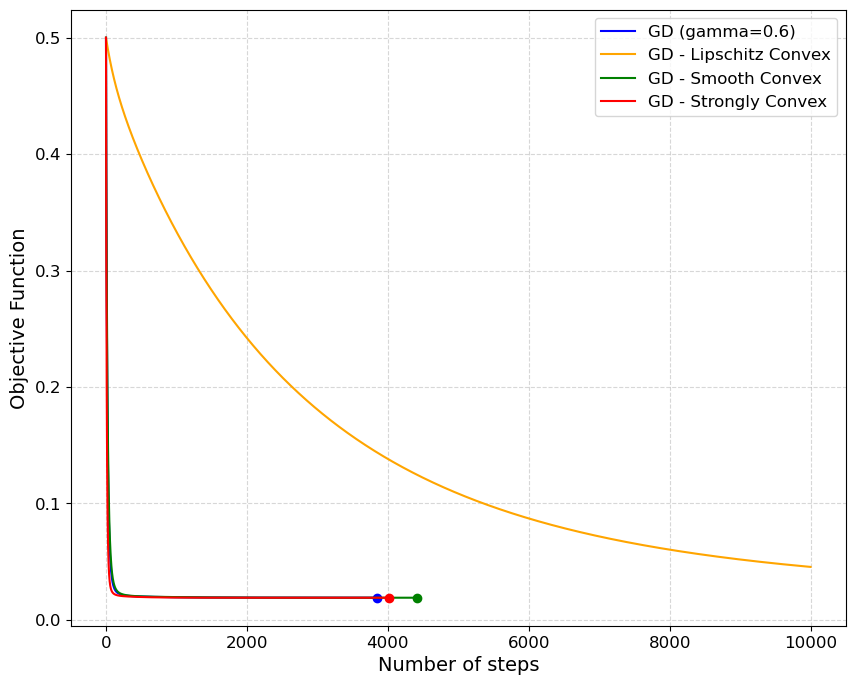

In [15]:
plt.figure(figsize=(10, 8))  
plt.xlabel('Number of steps', fontsize=14)
plt.ylabel('Objective Function', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.plot(range(len(f_gd)), f_gd, 'blue', label='GD (gamma=0.6)')
plt.plot(len(f_gd)-1, f_gd[-1], 'o', color='blue')
plt.plot(range(len(f_gd_L)), f_gd_L, 'orange', label='GD - Lipschitz Convex')
#plt.plot(len(f_gd_L)-1, f_gd_L[-1], 'o', color='orange')
plt.plot(range(len(f_gd_S)), f_gd_S, 'green', label='GD - Smooth Convex')
plt.plot(len(f_gd_S)-1, f_gd_S[-1], 'o', color='green')
plt.plot(range(len(f_gd_SC)), f_gd_SC, 'red', label='GD - Strongly Convex')
plt.plot(len(f_gd_SC)-1, f_gd_SC[-1], 'o', color='red')

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper right', fontsize=12)
plt.show()


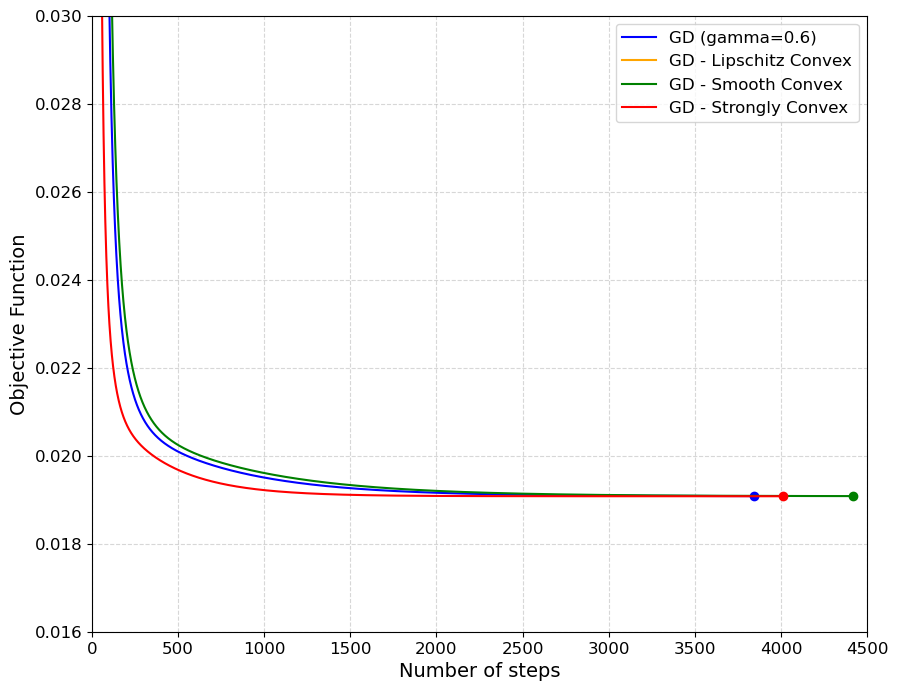

In [16]:
plt.figure(figsize=(10, 8))  
plt.xlabel('Number of steps', fontsize=14)
plt.ylabel('Objective Function', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.plot(range(len(f_gd)), f_gd, 'blue', label='GD (gamma=0.6)')
plt.plot(len(f_gd)-1, f_gd[-1], 'o', color='blue')
plt.plot(range(len(f_gd_L)), f_gd_L, 'orange', label='GD - Lipschitz Convex')
plt.plot(len(f_gd_L)-1, f_gd_L[-1], 'o', color='orange')
plt.plot(range(len(f_gd_S)), f_gd_S, 'green', label='GD - Smooth Convex')
plt.plot(len(f_gd_S)-1, f_gd_S[-1], 'o', color='green')
plt.plot(range(len(f_gd_SC)), f_gd_SC, 'red', label='GD - Strongly Convex')
plt.plot(len(f_gd_SC)-1, f_gd_SC[-1], 'o', color='red')

plt.grid(True, linestyle='--', alpha=0.5)
plt.ylim(0.016, 0.03)
plt.xlim(0, 4500)

plt.legend(loc='upper right', fontsize=12)
plt.show()


Now all with gd

---

In [17]:
def stochastic_gradient_descent(
    x0,
    X,
    y,
    grad_func,
    loss_func,
    learning_rate=None,
    max_iter=max_iter,
    batch_size=1,
    tol=1e-4,
    verbose=True,
    strongly=False,
    epochs=10
):
    n = X.shape[0]
    x = x0.copy()
    x_vals = [x.copy()]
    f_vals = []
    iteration = 0

    for epoch in range(1, epochs + 1):
        iter_per_epoch = max_iter // epochs

        for step in range(1, iter_per_epoch + 1):

            idx = np.random.choice(n, batch_size, replace=False)
            X_batch = X[idx] if isinstance(X, np.ndarray) else X.iloc[idx]
            y_batch = y[idx] if isinstance(y, np.ndarray) else y.iloc[idx]

            f_curr = loss_func(x, X_batch, y_batch)
            grad = grad_func(x, X_batch, y_batch)
            grad_norm = np.linalg.norm(grad)

            f_vals.append(f_curr)

            if np.isnan(f_curr) or f_curr > 1e6:
                print("STOP - Divergence detected")
                break

            if verbose:
                full_loss = loss_func(x, X, y)
                full_grad = grad_func(x, X, y)  
                full_grad_norm = np.linalg.norm(full_grad)
                print(f"   Epoch: {epoch}/{epochs} | Step: {step}/{iter_per_epoch}")
                print_log(
                    step=(epoch - 1) * iter_per_epoch + step,
                    f_curr=full_loss,
                    grad_norm=full_grad_norm,
                    batch_loss=f_curr
                )
                

            if grad_norm < tol:
                break

            gamma = learning_rate(iteration)
            x -= gamma * grad
            iteration += 1
            x_vals.append(x.copy())

    return f_vals, x_vals


In [18]:
def sgd(x0, gamma, max_iter, X, y, batch_size, epochs):
    """Stochastic gradient descent with fixed step size"""
    return stochastic_gradient_descent(
        x0=x0,
        grad_func=grad,
        loss_func=loss,
        learning_rate=lambda k: gamma,
        max_iter=max_iter,
        X=X,
        y=y,
        batch_size=batch_size,
        epochs=epochs
    )

def sgd_lipschitz(x0, max_iter, X, y, x_opt, batch_size, epochs):
    """Stochastic GD with step size based on Lipschitz estimate"""
    R = np.linalg.norm(x0 - x_opt)
    B = np.linalg.norm(grad(x0, X, y))  
    gamma = R / (B * np.sqrt(max_iter))
    
    return stochastic_gradient_descent(
        x0=x0,
        grad_func=grad,
        loss_func=loss,
        learning_rate=lambda k: gamma,
        max_iter=max_iter,
        X=X,
        y=y,
        batch_size=batch_size,
        epochs=epochs
    )

def sgd_strongly_convex(x0, max_iter, X, y, batch_size, t0, epochs):
    """Stochastic GD for strongly convex functions with decreasing learning rate"""
    n = X.shape[0]
    H = X.T @ X
    eigvals = np.linalg.eigvalsh(H)
    mu = np.min(eigvals) / n
    print(f"[INFO] mu = {mu:.3e}")

    if mu <= 0:
        print("[X] The function is NOT STRONGLY CONVEX: µ <= 0")
        return None, None

    return stochastic_gradient_descent(
        x0=x0,
        grad_func=grad,
        loss_func=loss,
        learning_rate = lambda t: 2 / (mu * (t0 + t + 1)),
        max_iter=max_iter,
        X=X,
        y=y,
        batch_size=batch_size,
        epochs=epochs,
        strongly=True
    )



In [19]:
max_iter = 10000
gamma = 5e-2
batch_size = 32
epochs = 20

print("[TRAIN] SGD:")
f_sgd, x_sgd = sgd(x0, gamma=gamma, max_iter=max_iter, X=X_train, y=y_train, batch_size=batch_size, epochs=epochs)

x_final = x_sgd[-1]
get_results(X_test, y_test, x_final, mu_y, std_y)

[TRAIN] SGD:
   Epoch: 1/20 | Step: 1/500
[STEP    1] batch loss = 0.35260 | f(x) = 0.50000 | ||grad|| = 3.10e-01
   Epoch: 1/20 | Step: 2/500
[STEP    2] batch loss = 0.44962 | f(x) = 0.49417 | ||grad|| = 2.94e-01
   Epoch: 1/20 | Step: 3/500
[STEP    3] batch loss = 0.27232 | f(x) = 0.48997 | ||grad|| = 2.84e-01
   Epoch: 1/20 | Step: 4/500
[STEP    4] batch loss = 0.39604 | f(x) = 0.48891 | ||grad|| = 2.86e-01
   Epoch: 1/20 | Step: 5/500
[STEP    5] batch loss = 0.49204 | f(x) = 0.48539 | ||grad|| = 2.78e-01
   Epoch: 1/20 | Step: 6/500
[STEP    6] batch loss = 0.46824 | f(x) = 0.48295 | ||grad|| = 2.76e-01
   Epoch: 1/20 | Step: 7/500
[STEP    7] batch loss = 0.42919 | f(x) = 0.48104 | ||grad|| = 2.76e-01
   Epoch: 1/20 | Step: 8/500
[STEP    8] batch loss = 0.50051 | f(x) = 0.47651 | ||grad|| = 2.64e-01
   Epoch: 1/20 | Step: 9/500
[STEP    9] batch loss = 0.51483 | f(x) = 0.47271 | ||grad|| = 2.57e-01
   Epoch: 1/20 | Step: 10/500
[STEP   10] batch loss = 0.35562 | f(x) = 0.4698

In [20]:
print("[TRAIN] SGD Lipschitz Convex:")
f_sgd_L, x_sgd_L = sgd_lipschitz(x0, max_iter=max_iter, X=X_train, y=y_train, x_opt=x_opt, batch_size=batch_size, epochs=epochs)

x_final = x_sgd_L[-1]
get_results(X_test, y_test, x_final, mu_y, std_y)

[TRAIN] SGD Lipschitz Convex:
   Epoch: 1/20 | Step: 1/500
[STEP    1] batch loss = 0.46712 | f(x) = 0.50000 | ||grad|| = 3.10e-01
   Epoch: 1/20 | Step: 2/500
[STEP    2] batch loss = 0.48073 | f(x) = 0.49952 | ||grad|| = 3.09e-01
   Epoch: 1/20 | Step: 3/500
[STEP    3] batch loss = 0.49556 | f(x) = 0.49933 | ||grad|| = 3.09e-01
   Epoch: 1/20 | Step: 4/500
[STEP    4] batch loss = 0.46378 | f(x) = 0.49894 | ||grad|| = 3.09e-01
   Epoch: 1/20 | Step: 5/500
[STEP    5] batch loss = 0.32933 | f(x) = 0.49859 | ||grad|| = 3.08e-01
   Epoch: 1/20 | Step: 6/500
[STEP    6] batch loss = 0.47216 | f(x) = 0.49814 | ||grad|| = 3.07e-01
   Epoch: 1/20 | Step: 7/500
[STEP    7] batch loss = 0.53258 | f(x) = 0.49770 | ||grad|| = 3.06e-01
   Epoch: 1/20 | Step: 8/500
[STEP    8] batch loss = 0.53360 | f(x) = 0.49710 | ||grad|| = 3.04e-01
   Epoch: 1/20 | Step: 9/500
[STEP    9] batch loss = 0.49554 | f(x) = 0.49679 | ||grad|| = 3.04e-01
   Epoch: 1/20 | Step: 10/500
[STEP   10] batch loss = 0.4056

In [21]:
t0 = 10000

print("[TRAIN] SGD Strongly Convex:")
f_sgd_SC, x_sgd_SC = sgd_strongly_convex(x0,  max_iter=max_iter, X=X_train, y=y_train, batch_size=batch_size, t0=t0, epochs=epochs)

x_final = x_sgd_SC[-1]
get_results(X_test, y_test, x_final, mu_y, std_y)

[TRAIN] SGD Strongly Convex:
[INFO] mu = 1.391e-03
   Epoch: 1/20 | Step: 1/500
[STEP    1] batch loss = 0.45940 | f(x) = 0.50000 | ||grad|| = 3.10e-01
   Epoch: 1/20 | Step: 2/500
[STEP    2] batch loss = 0.44676 | f(x) = 0.48449 | ||grad|| = 2.70e-01
   Epoch: 1/20 | Step: 3/500
[STEP    3] batch loss = 0.33201 | f(x) = 0.47864 | ||grad|| = 2.79e-01
   Epoch: 1/20 | Step: 4/500
[STEP    4] batch loss = 0.41634 | f(x) = 0.47026 | ||grad|| = 2.72e-01
   Epoch: 1/20 | Step: 5/500
[STEP    5] batch loss = 0.68916 | f(x) = 0.46283 | ||grad|| = 2.55e-01
   Epoch: 1/20 | Step: 6/500
[STEP    6] batch loss = 0.64429 | f(x) = 0.45131 | ||grad|| = 2.30e-01
   Epoch: 1/20 | Step: 7/500
[STEP    7] batch loss = 0.43734 | f(x) = 0.44093 | ||grad|| = 2.15e-01
   Epoch: 1/20 | Step: 8/500
[STEP    8] batch loss = 0.54359 | f(x) = 0.43458 | ||grad|| = 2.02e-01
   Epoch: 1/20 | Step: 9/500
[STEP    9] batch loss = 0.38944 | f(x) = 0.42891 | ||grad|| = 2.08e-01
   Epoch: 1/20 | Step: 10/500
[STEP   10

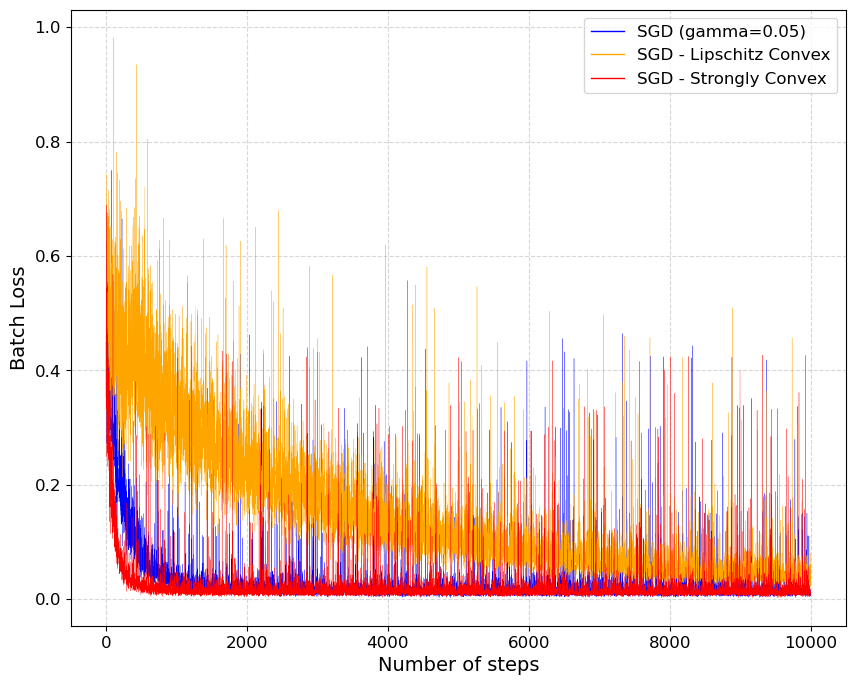

In [ ]:
plt.figure(figsize=(10, 8))  
plt.xlabel('Number of steps', fontsize=14)
plt.ylabel('Batch Loss', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.plot(range(len(f_sgd)), f_sgd, 'blue', label='SGD (gamma=0.05)', linewidth=0.2)
plt.plot(range(len(f_sgd_L)), f_sgd_L, 'orange', label='SGD - Lipschitz Convex', linewidth=0.2)
plt.plot(range(len(f_sgd_SC)), f_sgd_SC, 'red', label='SGD - Strongly Convex', linewidth=0.2)

legend_handles = [
    Line2D([0], [0], color='blue', lw=1, label='SGD (gamma=0.05)'),
    Line2D([0], [0], color='orange', lw=1, label='SGD - Lipschitz Convex'),
    Line2D([0], [0], color='red', lw=1, label='SGD - Strongly Convex')
]

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(handles=legend_handles, loc='upper right', fontsize=12)

plt.show()


---

In [23]:
def adagrad(
    x0,
    X,
    y,
    lr=0.1,
    eps=1e-8,
    max_iter=1000,
    tol=1e-4,
    verbose=True,
    epochs=10
):
    x = x0.copy()
    G = np.zeros_like(x)
    f_vals, x_vals = [loss(x, X, y)], [x.copy()]
    iteration = 0

    for epoch in range(1, epochs + 1):
        iter_per_epoch = max_iter // epochs

        for step in range(1, iter_per_epoch + 1):
            g = grad(x, X, y)
            grad_norm = np.linalg.norm(g)
            f_curr = loss(x, X, y)

            if verbose:
                print(f"   Epoch: {epoch}/{epochs} | Step: {step}/{iter_per_epoch}")
                print_log(
                    step=(epoch - 1) * iter_per_epoch + step,
                    f_curr=f_curr,
                    grad_norm=grad_norm
                )

            if grad_norm < tol:
                return f_vals, x_vals

            G += g**2
            x -= (lr / (np.sqrt(G) + eps)) * g

            x_vals.append(x.copy())
            f_vals.append(f_curr)
            iteration += 1

    return f_vals, x_vals


In [24]:
def adam(
    x0,
    X,
    y,
    lr=0.001,
    beta1=0.9,
    beta2=0.999,
    eps=1e-8,
    max_iter=1000,
    tol=1e-4,
    verbose=True,
    epochs=10
):
    x = x0.copy()
    m = np.zeros_like(x)
    v = np.zeros_like(x)
    f_vals, x_vals = [loss(x, X, y)], [x.copy()]
    iteration = 0

    for epoch in range(1, epochs + 1):
        iter_per_epoch = max_iter // epochs

        for step in range(1, iter_per_epoch + 1):
            g = grad(x, X, y)
            grad_norm = np.linalg.norm(g)
            f_curr = loss(x, X, y)

            if verbose:
                print(f"   Epoch: {epoch}/{epochs} | Step: {step}/{iter_per_epoch}")
                print_log(
                    step=(epoch - 1) * iter_per_epoch + step,
                    f_curr=f_curr,
                    grad_norm=grad_norm
                )

            if grad_norm < tol:
                return f_vals, x_vals

            m = beta1 * m + (1 - beta1) * g
            v = beta2 * v + (1 - beta2) * (g ** 2)

            m_hat = m / (1 - beta1 ** (iteration + 1))
            v_hat = v / (1 - beta2 ** (iteration + 1))

            x -= lr * m_hat / (np.sqrt(v_hat) + eps)

            x_vals.append(x.copy())
            f_vals.append(f_curr)
            iteration += 1

    return f_vals, x_vals


In [25]:
gamma = 0.4

print("[TRAIN] Adagrad:")
f_AG, x_AG = adagrad(x0, X_train, y_train, lr=gamma, max_iter=max_iter, epochs=epochs)
x_final = x_AG[-1]
get_results(X_test, y_test, x_final, mu_y, std_y)

[TRAIN] Adagrad:
   Epoch: 1/20 | Step: 1/500
[STEP    1] f(x) = 0.50000 | ||grad|| = 3.10e-01
   Epoch: 1/20 | Step: 2/500
[STEP    2] f(x) = 0.72197 | ||grad|| = 1.06e+00
   Epoch: 1/20 | Step: 3/500
[STEP    3] f(x) = 0.57555 | ||grad|| = 1.19e+00
   Epoch: 1/20 | Step: 4/500
[STEP    4] f(x) = 0.29119 | ||grad|| = 7.45e-01
   Epoch: 1/20 | Step: 5/500
[STEP    5] f(x) = 0.14026 | ||grad|| = 3.42e-01
   Epoch: 1/20 | Step: 6/500
[STEP    6] f(x) = 0.09360 | ||grad|| = 1.62e-01
   Epoch: 1/20 | Step: 7/500
[STEP    7] f(x) = 0.07334 | ||grad|| = 9.05e-02
   Epoch: 1/20 | Step: 8/500
[STEP    8] f(x) = 0.06107 | ||grad|| = 6.76e-02
   Epoch: 1/20 | Step: 9/500
[STEP    9] f(x) = 0.05242 | ||grad|| = 5.54e-02
   Epoch: 1/20 | Step: 10/500
[STEP   10] f(x) = 0.04598 | ||grad|| = 4.91e-02
   Epoch: 1/20 | Step: 11/500
[STEP   11] f(x) = 0.04105 | ||grad|| = 4.35e-02
   Epoch: 1/20 | Step: 12/500
[STEP   12] f(x) = 0.03722 | ||grad|| = 3.92e-02
   Epoch: 1/20 | Step: 13/500
[STEP   13] f(

In [26]:
print("[TRAIN] Adam:")
f_AD, x_AD = adam(x0, X_train, y_train, lr=gamma, max_iter=max_iter, epochs=epochs)
x_final = x_AD[-1]
get_results(X_test, y_test, x_final, mu_y, std_y)

[TRAIN] Adam:
   Epoch: 1/20 | Step: 1/500
[STEP    1] f(x) = 0.50000 | ||grad|| = 3.10e-01
   Epoch: 1/20 | Step: 2/500
[STEP    2] f(x) = 0.72197 | ||grad|| = 1.06e+00
   Epoch: 1/20 | Step: 3/500
[STEP    3] f(x) = 0.44041 | ||grad|| = 8.99e-01
   Epoch: 1/20 | Step: 4/500
[STEP    4] f(x) = 0.25586 | ||grad|| = 6.28e-01
   Epoch: 1/20 | Step: 5/500
[STEP    5] f(x) = 0.25651 | ||grad|| = 6.38e-01
   Epoch: 1/20 | Step: 6/500
[STEP    6] f(x) = 0.28212 | ||grad|| = 7.91e-01
   Epoch: 1/20 | Step: 7/500
[STEP    7] f(x) = 0.16497 | ||grad|| = 5.15e-01
   Epoch: 1/20 | Step: 8/500
[STEP    8] f(x) = 0.13054 | ||grad|| = 2.77e-01
   Epoch: 1/20 | Step: 9/500
[STEP    9] f(x) = 0.21314 | ||grad|| = 5.51e-01
   Epoch: 1/20 | Step: 10/500
[STEP   10] f(x) = 0.22101 | ||grad|| = 5.88e-01
   Epoch: 1/20 | Step: 11/500
[STEP   11] f(x) = 0.14442 | ||grad|| = 3.79e-01
   Epoch: 1/20 | Step: 12/500
[STEP   12] f(x) = 0.10761 | ||grad|| = 2.85e-01
   Epoch: 1/20 | Step: 13/500
[STEP   13] f(x) 

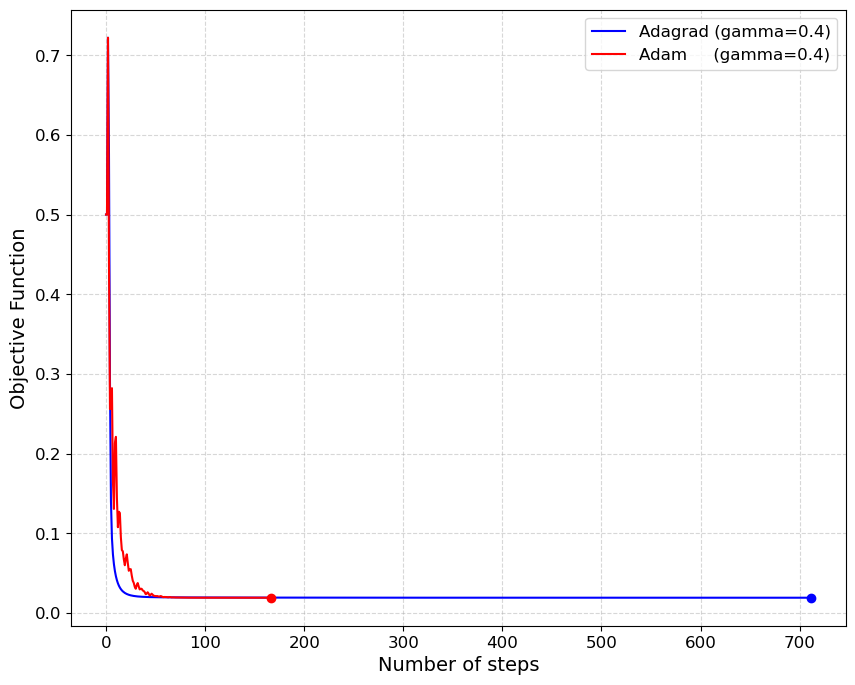

In [35]:
plt.figure(figsize=(10, 8))  
plt.xlabel('Number of steps', fontsize=14)
plt.ylabel('Objective Function', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.plot(range(len(f_AG)), f_AG, 'blue', label='Adagrad (gamma=0.4)')
plt.plot(len(f_AG)-1, f_AG[-1], 'o', color='blue')
plt.plot(range(len(f_AD)), f_AD, 'red', label='Adam     (gamma=0.4)')
plt.plot(len(f_AD)-1, f_AD[-1], 'o', color='red')

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper right', fontsize=12)
plt.show()


---

In [28]:
def newton_raphson_method(
    x0, 
    X, 
    y, 
    max_iter=100, 
    tol=1e-4, 
    verbose=True
):
    x = x0.copy()
    x_vals = [x.copy()]
    f_vals = [loss(x, X, y)]

    for step in range(1, max_iter + 1):
        g = grad(x, X, y)
        H = hess(x, X, y)
        grad_norm = np.linalg.norm(g)
        f_curr = loss(x, X, y)

        if np.isnan(f_curr) or f_curr > 1e6:
            print("STOP - Divergence detected")
            break

        if verbose:
            print_log(step, f_curr, grad_norm)

        if grad_norm < tol:
            break

        try:
            delta = np.linalg.solve(H, g)
        except np.linalg.LinAlgError:
            print("STOP - Hessian not invertible")
            break

        x -= delta
        x_vals.append(x.copy())
        f_vals.append(loss(x, X, y))

    return f_vals, x_vals


In [36]:
print("[TRAIN] Newton-Raphson Method:")
f_NR, x_NR = newton_raphson_method(x0, X_train, y_train, max_iter=max_iter)
x_final = x_NR[-1]
get_results(X_test, y_test, x_final, mu_y, std_y)


[TRAIN] Newton-Raphson Method:
[STEP    1] f(x) = 0.50000 | ||grad|| = 3.10e-01
[STEP    2] f(x) = 0.01908 | ||grad|| = 5.06e-16
[TEST] R2:   0.957
[TEST] MSE:  5.105 s²
[TEST] RMSE: 2.259 s


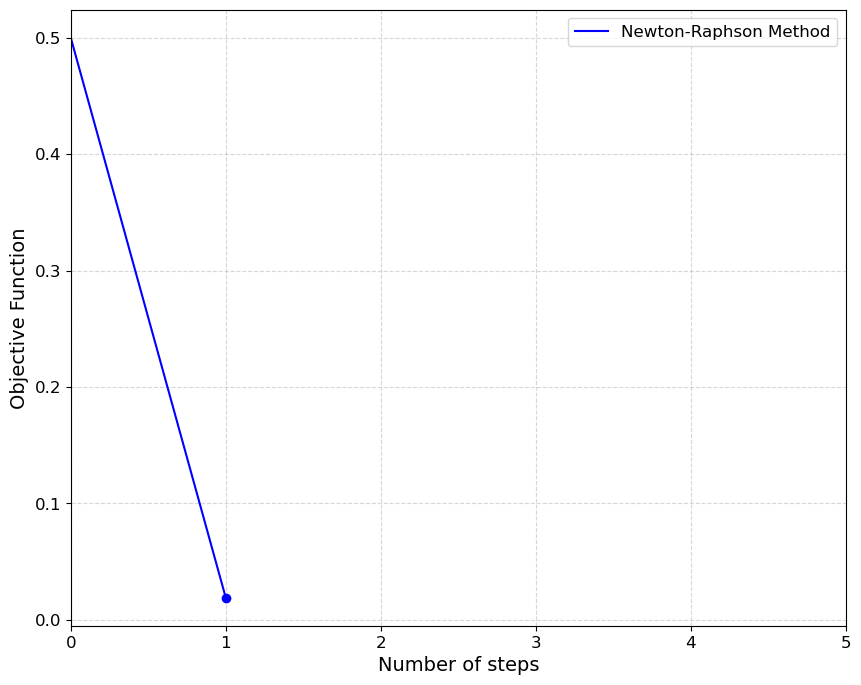

In [40]:
plt.figure(figsize=(10, 8))  
plt.xlabel('Number of steps', fontsize=14)
plt.ylabel('Objective Function', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.plot(range(len(f_NR)), f_NR, 'blue', label='Newton-Raphson Method')
plt.plot(len(f_NR)-1, f_NR[-1], 'o', color='blue')

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper right', fontsize=12)
plt.xlim(0, 5)
plt.show()

---

In [41]:
def random_coordinate_gradient_descent(
    x0,
    X,
    y,
    max_iter=100,
    tol=1e-4,
    verbose=True,
    seed=None
):
    np.random.seed(seed)
    x = x0.copy()
    n_samples, n_features = X.shape
    x_vals = [x.copy()]
    f_vals = [loss(x, X, y)]
    L = (1 / n_samples) * np.sum(X ** 2, axis=0)  # Coordinate-wise Lipschitz constants

    for step in range(1, max_iter + 1):
        f_curr = loss(x, X, y)
        grad_full = grad(x, X, y)
        grad_norm = np.linalg.norm(grad_full)

        if np.isnan(f_curr) or f_curr > 1e6:
            print("STOP - Divergence detected")
            break

        if verbose:
            print_log(step, f_curr, grad_norm)

        if grad_norm < tol:
            break

        j = np.random.randint(n_features)

        residuals = X @ x - y
        g_j = (1 / n_samples) * np.dot(X[:, j], residuals)
        if L[j] > 0:
            x[j] -= g_j / L[j]

        x_vals.append(x.copy())
        f_vals.append(loss(x, X, y))

    return f_vals, x_vals


In [42]:
print("[TRAIN] Random Coordinate Gradient Descent:")
f_RCGD, x_RCGD = random_coordinate_gradient_descent(x0, X_train, y_train, max_iter=max_iter)
x_final = x_RCGD[-1]
get_results(X_test, y_test, x_final, mu_y, std_y)

[TRAIN] Random Coordinate Gradient Descent:
[STEP    1] f(x) = 0.50000 | ||grad|| = 3.10e-01
[STEP    2] f(x) = 0.49990 | ||grad|| = 3.10e-01
[STEP    3] f(x) = 0.49985 | ||grad|| = 3.10e-01
[STEP    4] f(x) = 0.48559 | ||grad|| = 2.65e-01
[STEP    5] f(x) = 0.48552 | ||grad|| = 2.65e-01
[STEP    6] f(x) = 0.48552 | ||grad|| = 2.65e-01
[STEP    7] f(x) = 0.48552 | ||grad|| = 2.65e-01
[STEP    8] f(x) = 0.47777 | ||grad|| = 2.23e-01
[STEP    9] f(x) = 0.47118 | ||grad|| = 2.29e-01
[STEP   10] f(x) = 0.47114 | ||grad|| = 2.29e-01
[STEP   11] f(x) = 0.47080 | ||grad|| = 2.27e-01
[STEP   12] f(x) = 0.39616 | ||grad|| = 2.12e-01
[STEP   13] f(x) = 0.39304 | ||grad|| = 2.18e-01
[STEP   14] f(x) = 0.39304 | ||grad|| = 2.18e-01
[STEP   15] f(x) = 0.35975 | ||grad|| = 2.09e-01
[STEP   16] f(x) = 0.34338 | ||grad|| = 2.11e-01
[STEP   17] f(x) = 0.32904 | ||grad|| = 2.01e-01
[STEP   18] f(x) = 0.32685 | ||grad|| = 2.04e-01
[STEP   19] f(x) = 0.32379 | ||grad|| = 2.12e-01
[STEP   20] f(x) = 0.3237

In [43]:
def steepest_coordinate_gradient_descent(
    x0,
    X,
    y,
    max_iter=100,
    tol=1e-4,
    verbose=True
):
    x = x0.copy()
    n_samples, n_features = X.shape
    x_vals = [x.copy()]
    f_vals = [loss(x, X, y)]
    L = (1 / n_samples) * np.sum(X ** 2, axis=0)  # Coordinate-wise Lipschitz constants

    for step in range(1, max_iter + 1):
        f_curr = loss(x, X, y)
        grad_full = grad(x, X, y)
        grad_norm = np.linalg.norm(grad_full)

        if np.isnan(f_curr) or f_curr > 1e6:
            print("STOP - Divergence detected")
            break

        if verbose:
            print_log(step, f_curr, grad_norm)

        if grad_norm < tol:
            break

        # Calcola il miglior passo in base a |grad_j|^2 / L_j
        scores = np.abs(grad_full) ** 2 / (L + 1e-12)  # Aggiunto epsilon per evitare div/0
        j = np.argmax(scores)

        residuals = X @ x - y
        g_j = (1 / n_samples) * np.dot(X[:, j], residuals)
        if L[j] > 0:
            x[j] -= g_j / L[j]

        x_vals.append(x.copy())
        f_vals.append(loss(x, X, y))

    return f_vals, x_vals


In [44]:
print("[TRAIN] Steepest Coordinate Gradient Descent:")
f_SCGD, x_SCGD = steepest_coordinate_gradient_descent(x0, X_train, y_train, max_iter=max_iter)
x_final = x_SCGD[-1]
get_results(X_test, y_test, x_final, mu_y, std_y)

[TRAIN] Steepest Coordinate Gradient Descent:
[STEP    1] f(x) = 0.50000 | ||grad|| = 3.10e-01
[STEP    2] f(x) = 0.41218 | ||grad|| = 3.29e-01
[STEP    3] f(x) = 0.33563 | ||grad|| = 2.57e-01
[STEP    4] f(x) = 0.27538 | ||grad|| = 2.60e-01
[STEP    5] f(x) = 0.24294 | ||grad|| = 3.09e-01
[STEP    6] f(x) = 0.21790 | ||grad|| = 3.16e-01
[STEP    7] f(x) = 0.18647 | ||grad|| = 1.98e-01
[STEP    8] f(x) = 0.16729 | ||grad|| = 2.11e-01
[STEP    9] f(x) = 0.14919 | ||grad|| = 1.75e-01
[STEP   10] f(x) = 0.13378 | ||grad|| = 1.73e-01
[STEP   11] f(x) = 0.11839 | ||grad|| = 1.81e-01
[STEP   12] f(x) = 0.10637 | ||grad|| = 1.64e-01
[STEP   13] f(x) = 0.09460 | ||grad|| = 1.65e-01
[STEP   14] f(x) = 0.08541 | ||grad|| = 7.96e-02
[STEP   15] f(x) = 0.07602 | ||grad|| = 7.45e-02
[STEP   16] f(x) = 0.06917 | ||grad|| = 9.12e-02
[STEP   17] f(x) = 0.06240 | ||grad|| = 9.55e-02
[STEP   18] f(x) = 0.05729 | ||grad|| = 8.05e-02
[STEP   19] f(x) = 0.05220 | ||grad|| = 8.25e-02
[STEP   20] f(x) = 0.04

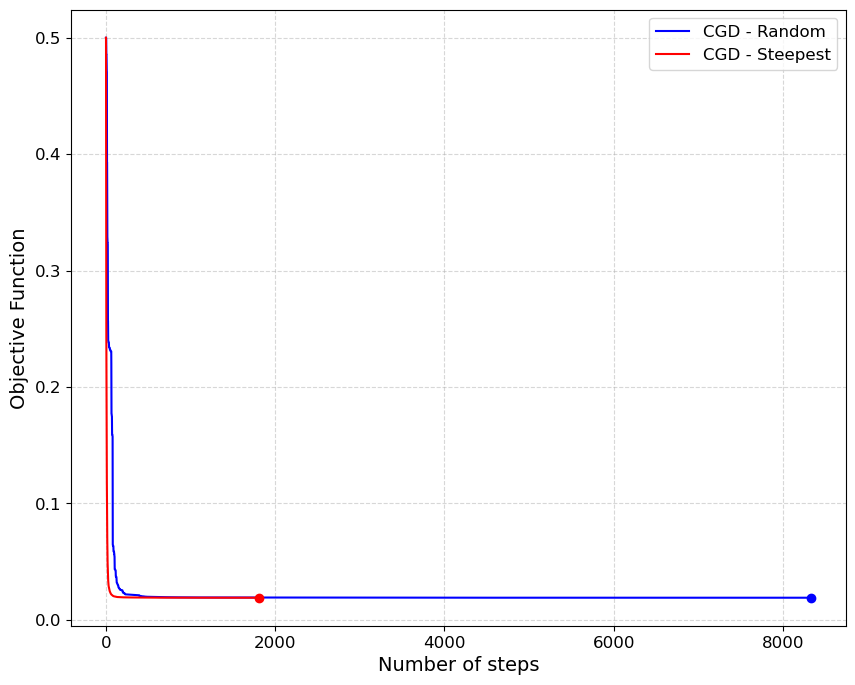

In [46]:
plt.figure(figsize=(10, 8))  
plt.xlabel('Number of steps', fontsize=14)
plt.ylabel('Objective Function', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.plot(range(len(f_RCGD)), f_RCGD, 'blue', label='CGD - Random')
plt.plot(len(f_RCGD)-1, f_RCGD[-1], 'o', color='blue')
plt.plot(range(len(f_SCGD)), f_SCGD, 'red', label='CGD - Steepest')
plt.plot(len(f_SCGD)-1, f_SCGD[-1], 'o', color='red')

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper right', fontsize=12)
plt.show()


---

In [52]:
def loss_ridge(w, X, y, lmbda):
    n = X.shape[0]
    residuals = X @ w - y
    return (1 / (2 * n)) * np.sum(residuals ** 2) + lmbda * np.sum(w**2)

def loss_lasso(w, X, y, lmbda):
    n = X.shape[0]
    residuals = X @ w - y
    return (1 / (2 * n)) * np.sum(residuals ** 2) + lmbda * np.sum(np.abs(w))


In [ ]:
def proximal_gradient_descent(
    x0,
    X,
    y,
    lmbda,
    max_iter=100,
    learning_rate=1e-2,
    tol=1e-4,
    method="ridge",  # "ridge" or "lasso"
    verbose=True
):
    x = x0.copy()
    x_vals = [x.copy()]

    if method == "ridge":
        loss_fn = loss_ridge
        prox_fn = prox_ridge
    elif method == "lasso":
        loss_fn = loss_lasso
        prox_fn = prox_lasso
    else:
        raise ValueError("Metodo non valido: scegli 'ridge' o 'lasso'")

    f_vals = [loss_fn(x, X, y, lmbda)]

    for step in range(1, max_iter + 1):
        g = grad(x, X, y)
        x_new = prox_fn(x - learning_rate * g, learning_rate, lmbda)

        f_curr = loss_fn(x_new, X, y, lmbda)
        grad_norm = np.linalg.norm(x_new - x) / max(1e-8, np.linalg.norm(x))

        if np.isnan(f_curr) or f_curr > 1e6:
            print("STOP - Divergenza rilevata")
            break

        if verbose:
            print_log(step, f_curr, grad_norm)

        if grad_norm < tol:
            break

        x = x_new
        x_vals.append(x.copy())
        f_vals.append(f_curr)

    return f_vals, x_vals


In [ ]:
gamma = 

print("[TRAIN] Proximal Gradient Descent - Ridge:")
f_pg_ridge, x_pg_ridge = proximal_gradient_descent(x0, X_train, y_train, lmbda=0.1, max_iter=100, eta=1e-2, method="ridge"
)
x_final = x_pg_ridge_S[-1]
get_results(X_test, y_test, x_final, mu_y, std_y)


In [ ]:

print("[TRAIN] Proximal Gradient Descent - Lasso:")
f_pg_lasso, x_pg_lasso = proximal_gradient_descent(
    x0, X_train, y_train, lmbda=0.1, max_iter=100, eta=1e-2, method="lasso"
)


In [ ]:
event_categories = sorted(set(event_name))
team_categories = sorted(set(team))
compound_categories = sorted(set(compound))
fresh_tyre_categories = sorted(set(fresh_tyre))
rainfall_categories = sorted(set(rainfall))

event_feature_names = [f"Event name [{cat}]" for cat in event_categories]
team_feature_names = [f"Team [{cat}]" for cat in team_categories]
compound_feature_names = [f"Compound [{cat}]" for cat in compound_categories]
fresh_tyre_feature_names = [f"Fresh tyre [{cat}]" for cat in fresh_tyre_categories]
rainfall_feature_names = [f"Rainfall [{cat}]" for cat in rainfall_categories]

num_feature_names = [
    "Tyre life",
    #"Air temp",
    #"Humidity",
    #"Pressure",
    "Track temp",
    "Wind direction",
    "Wind speed",
    "Fuel level"
]

feature_names = (
    ["bias"] +
    event_feature_names +
    team_feature_names +
    compound_feature_names +
    fresh_tyre_feature_names +
    rainfall_feature_names +
    num_feature_names
)

coeff_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": x_final
})

def style_coeff(val, tol=1e-6):
    styles = []
    if abs(val) < tol:
        color = 'color: grey'
    else:
        color = 'color: green' if val > 0 else 'color: red'
    style = f'{color}; font-weight: bold'
    return style


row_styles = [
    {'selector': f'tbody tr:nth-child({i+1})', 'props': [('opacity', '0.4')]}
    for i, val in enumerate(coeff_df['Coefficient'])
    if abs(val) < 0.1
]

coeff_df_styled = (
    coeff_df.style
    .format({'Coefficient': '{:.3f}'})
    .map(style_coeff, subset=['Coefficient'])
    .set_table_styles(row_styles)
)

coeff_df_styled


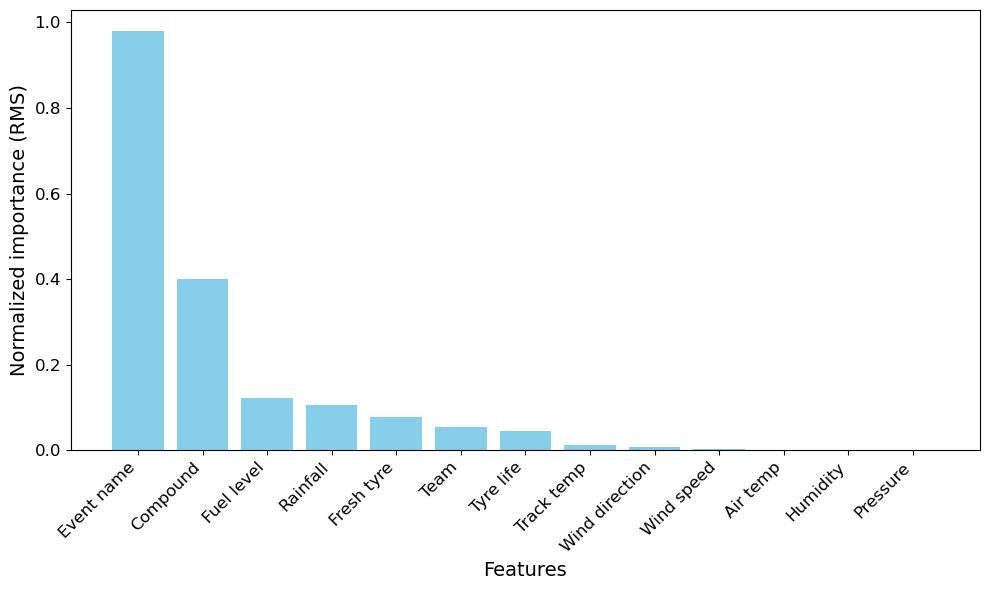

In [ ]:
categorical_vars = {
    "Event name": event_feature_names,
    "Team": team_feature_names,
    "Compound": compound_feature_names,
    "Fresh tyre": fresh_tyre_feature_names,
    "Rainfall": rainfall_feature_names
}

numeric_feature_names = [
    "Tyre life",
    "Air temp",
    "Humidity",
    "Pressure",
    "Track temp",
    "Wind direction",
    "Wind speed",
    "Fuel level"
]

def plot_shrinkage(x_final): 

    coeff_df = pd.DataFrame({
        "Feature": feature_names,
        "Coefficient": x_final
    })

    # Exclude 'bias'
    coeff_df = coeff_df[coeff_df['Feature'] != 'bias']

    importance = {}

    # Categorical variables: RMS (root mean square) of dummy coefficients
    for var_name, dummy_features in categorical_vars.items():
        coeffs = coeff_df.loc[coeff_df['Feature'].isin(dummy_features), 'Coefficient'].values
        if len(coeffs) > 0:
            rms = np.sqrt(np.sum(coeffs**2) / len(coeffs))  # normalized L2
            importance[var_name] = rms
        else:
            importance[var_name] = 0

    # Numeric variables: absolute value of the single coefficient
    for num_var in numeric_feature_names:
        coeff = coeff_df.loc[coeff_df['Feature'] == num_var, 'Coefficient'].values
        if len(coeff) > 0:
            importance[num_var] = abs(coeff[0])
        else:
            importance[num_var] = 0

    # Sort by descending importance
    importance = dict(sorted(importance.items(), key=lambda item: item[1], reverse=True))

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(importance.keys(), importance.values(), color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Features', fontsize=14)
    plt.ylabel('Normalized importance (RMS)', fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tight_layout()
    plt.show()

plot_shrinkage(x_final)

---

## Lasso e Proximal Gradient Descent

La regressione **Lasso** minimizza la seguente funzione obiettivo:

$$
\min_{\beta} \left[ f(\beta) := \frac{1}{2} \|X\beta - y\|^2 + \lambda \|\beta\|_1 \right]
$$

Dove:

$$
\frac{1}{2} \|X\beta - y\|^2
$$  
è una funzione **differenziabile** (quadratica)

$$
\lambda \|\beta\|_1
$$  
è **non differenziabile** ma **convessa**


## Proximal Gradient Descent

Il **Proximal Gradient Descent** si applica a problemi del tipo:

$$
\min_\beta \left[ f(\beta) + g(\beta) \right]
$$

Dove:

$$
f(\beta)
$$  
è **differenziabile** con gradiente Lipschitz continuo

$$
g(\beta)
$$  
è **non differenziabile** ma ha un **operatore prossimale noto**


In [ ]:
def loss_lasso(w, X, y, lam):
    n = X.shape[0]
    residuals = X @ w - y
    return (1 / (2 * n)) * np.dot(residuals, residuals) + lam * np.linalg.norm(w, 1)

def soft_thresholding(x, thresh):
    return np.sign(x) * np.maximum(np.abs(x) - thresh, 0.0)


In [ ]:
def proximal_gradient_descent(
    x0,
    grad_func,
    loss_func,
    prox_operator,
    learning_rate,
    lam,
    max_iter,
    f_star=None,
    tol=1e-6,
    verbose=True
):
    x = x0.copy()
    x_vals = [x.copy()]
    f_vals = [loss_func(x)]

    for step in range(1, max_iter + 1):
        g = grad_func(x)
        grad_norm = np.linalg.norm(g)
        f_curr = loss_func(x)

        if np.isnan(f_curr) or f_curr > 1e6:
            print("STOP - Divergence detected")
            break

        if verbose and f_star is not None:
            print_log(step, f_curr, f_star, grad_norm)

        if grad_norm < tol:
            break

        gamma = learning_rate(step)
        x = prox_operator(x - gamma * g, gamma * lam)

        x_vals.append(x.copy())
        f_vals.append(loss_func(x))

    return f_vals, x_vals


In [ ]:
def pxgd_smooth(x0, lam, max_iter, X, y):
    H = X.T @ X
    n = X.shape[0]
    L = np.linalg.norm(H, 2) / n
    gamma = 1.0 / L
    return proximal_gradient_descent(
        x0=x0,
        grad_func=lambda x: grad(x, X, y),
        loss_func=lambda x: loss_lasso(x, X, y, lam),
        prox_operator=soft_thresholding,
        learning_rate=lambda k: gamma,
        lam=lam,
        max_iter=max_iter,
        f_star=f_opt
    )

In [ ]:
lam = 5e-3

print("[TRAIN] PXGD Lasso Smooth:")
f_pxgd_S, x_pxgd_S = pxgd_smooth(    x0, lam=lam, max_iter=max_iter, X=X_train, y=y_train)

x_final = x_pxgd_S[-1]
get_results(X_test, y_test, x_final, mu_y, std_y)

[TRAIN] PXGD Lasso Strongly Convex:
[STEP    1] f(x) = 0.50000 | f(x*) = 0.01908 | Δ = 4.81e-01 | ||grad|| = 3.18e-01
[STEP    2] f(x) = 0.47488 | f(x*) = 0.01908 | Δ = 4.56e-01 | ||grad|| = 2.59e-01
[STEP    3] f(x) = 0.45815 | f(x*) = 0.01908 | Δ = 4.39e-01 | ||grad|| = 2.29e-01
[STEP    4] f(x) = 0.44504 | f(x*) = 0.01908 | Δ = 4.26e-01 | ||grad|| = 2.13e-01
[STEP    5] f(x) = 0.43371 | f(x*) = 0.01908 | Δ = 4.15e-01 | ||grad|| = 2.03e-01
[STEP    6] f(x) = 0.42339 | f(x*) = 0.01908 | Δ = 4.04e-01 | ||grad|| = 1.96e-01
[STEP    7] f(x) = 0.41375 | f(x*) = 0.01908 | Δ = 3.95e-01 | ||grad|| = 1.91e-01
[STEP    8] f(x) = 0.40462 | f(x*) = 0.01908 | Δ = 3.86e-01 | ||grad|| = 1.87e-01
[STEP    9] f(x) = 0.39590 | f(x*) = 0.01908 | Δ = 3.77e-01 | ||grad|| = 1.83e-01
[STEP   10] f(x) = 0.38755 | f(x*) = 0.01908 | Δ = 3.68e-01 | ||grad|| = 1.80e-01
[STEP   11] f(x) = 0.37952 | f(x*) = 0.01908 | Δ = 3.60e-01 | ||grad|| = 1.77e-01
[STEP   12] f(x) = 0.37180 | f(x*) = 0.01908 | Δ = 3.53e-01 | 

In [ ]:
coeff_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": x_final
})

row_styles = [
    {'selector': f'tbody tr:nth-child({i+1})', 'props': [('opacity', '0.4')]}
    for i, val in enumerate(coeff_df['Coefficient'])
    if val == 0
]

coeff_df_styled = (
    coeff_df.style
    .format({'Coefficient': '{:.3f}'})
    .map(style_coeff, subset=['Coefficient'])
    .set_table_styles(row_styles)
)

coeff_df_styled

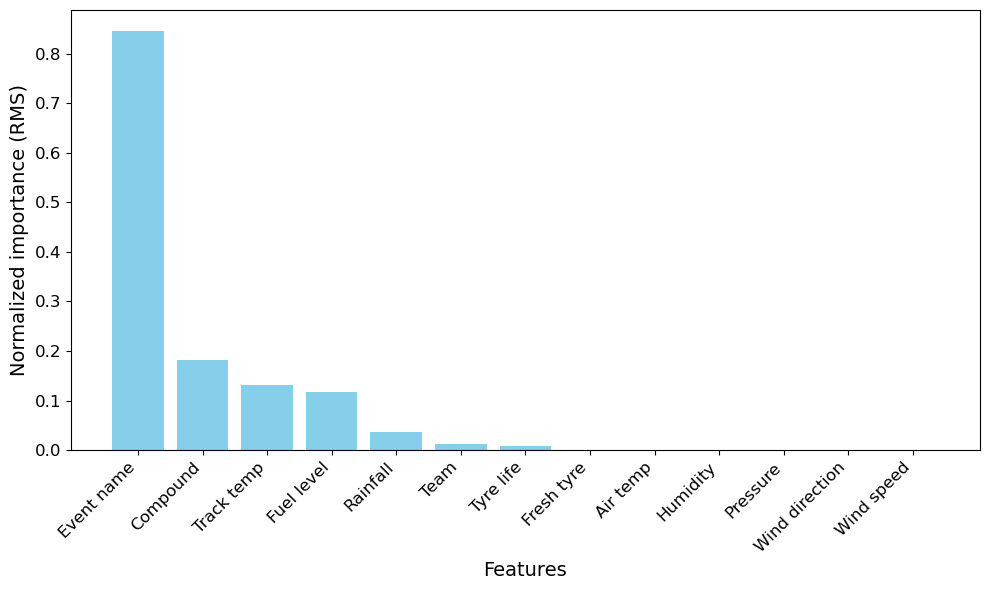

In [ ]:
plot_shrinkage(x_final)

---